# Lectura de archivos

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id = '1FAjcexe-71nGuYIzvnQ46IdXVcqM9cx4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values_complete_features.csv')

test_values1 = pd.read_csv('test_values_complete_features.csv', encoding='latin-1', index_col='building_id')

test_values1[test_values1.select_dtypes('O').columns] = test_values1[test_values1.select_dtypes('O').columns].astype('category')

In [4]:
id = '1qs2mEnkqiAqebJE2SvqkrfoV66Edguwr'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values_complete_features.csv')

train_values1 = pd.read_csv('train_values_complete_features.csv', encoding='latin-1', index_col='building_id')

train_values1[train_values1.select_dtypes('O').columns] = train_values1[train_values1.select_dtypes('O').columns].astype('category')

In [5]:
id='1RUtolRcQlR3RGULttM4ZoQaK_Ouow4gc'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_labels.csv')
train_labels = pd.read_csv('train_labels.csv', encoding='latin-1', dtype={'building_id': 'int64', 'damage_grade': 'int64'}, index_col='building_id')

In [6]:
id='1br3fMwXX_J0XmiXvOm_wfKWvHSj45T3y'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')
train_values2 = pd.read_csv('train_values.csv', encoding='latin-1', index_col='building_id')

train_values2[train_values2.select_dtypes('O').columns] = train_values2[train_values2.select_dtypes('O').columns].astype('category')

In [7]:
id = '1kt2VFhgpfRS72wtBOBy1KDat9LanfMZU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values.csv')
test_values2 = pd.read_csv('test_values.csv', encoding='latin-1', index_col='building_id')

test_values2[test_values2.select_dtypes('O').columns] = test_values2[test_values2.select_dtypes('O').columns].astype('category')

In [8]:
train_values_complete = train_values1.copy()
test_values_complete = test_values1.copy()
train_values_incomplete = train_values2.copy()
test_values_incomplete = test_values2.copy()

# XGBoost (muy buena prueba)

In [9]:
train_values = train_values_incomplete.copy()
test_values = test_values_incomplete.copy()

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train_values['legal_ownership_status'].dtype

CategoricalDtype(categories=['a', 'r', 'v', 'w'], ordered=False)

In [11]:
def get_obj(train, p = False):
    obj_types = []
    for column in train.columns:
        if column in train.select_dtypes('category').columns: 
            if p: print(column)
            obj_types.append(column)
    return obj_types
    
obj_types = get_obj(train_values, True)

land_surface_condition
foundation_type
roof_type
ground_floor_type
other_floor_type
position
plan_configuration
legal_ownership_status


In [12]:
def transform_to_int(train, obj_types):
    #Assign dictionaries with current values and replacements for each column
    d_lsc = {'n':0, 'o':1, 't':2}
    d_ft = {'h':0, 'i':1, 'r':2, 'u':3, 'w':4}
    d_rt = {'n':0, 'q':1, 'x':2}
    d_gft = {'f':0, 'm':1, 'v':2, 'x':3, 'z':4}
    d_oft = {'j':0, 'q':1, 's':2, 'x':3}
    d_pos = {'j':0, 'o':1, 's':2, 't':3}
    d_pc = {'a':0, 'c':1, 'd':2, 'f':3, 'm':4, 'n':5, 'o':6, 'q':7, 's':8, 'u':9}
    d_los = {'a':0, 'r':1, 'v':2, 'w':3}
    #Each positional index in replacements corresponds to the column in obj_types
    replacements = [d_lsc, d_ft, d_rt, d_gft, d_oft, d_pos, d_pc, d_los]

    #Replace using lambda Series.map(lambda)
    for i,col in enumerate(obj_types):
        train[col] = train[col].map(lambda a: replacements[i][a]).astype('int64')
        
transform_to_int(train_values, obj_types)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(train_values, train_labels)

rcf = RandomForestClassifier()
model = rcf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
y_pred = model.predict(x_test)
f1_score(y_test, y_pred,average='micro')

0.7174563705852558

In [54]:
importance = pd.DataFrame({"Feature":list(train_values), "Importance": rcf.feature_importances_}) # build a dataframe with features and their importance
importance = importance.sort_values(by="Importance", ascending=False) #sort by importance
importance

,Feature,Importance
2,geo_level_3_id,0.153942
0,geo_level_1_id,0.139163
1,geo_level_2_id,0.135332
4,age,0.121427
5,area_percentage,0.111355
6,height_percentage,0.056061
26,count_families,0.025055
8,foundation_type,0.024376
9,roof_type,0.024338
12,position,0.021688


Elimino outliers de los parámetros más importantes

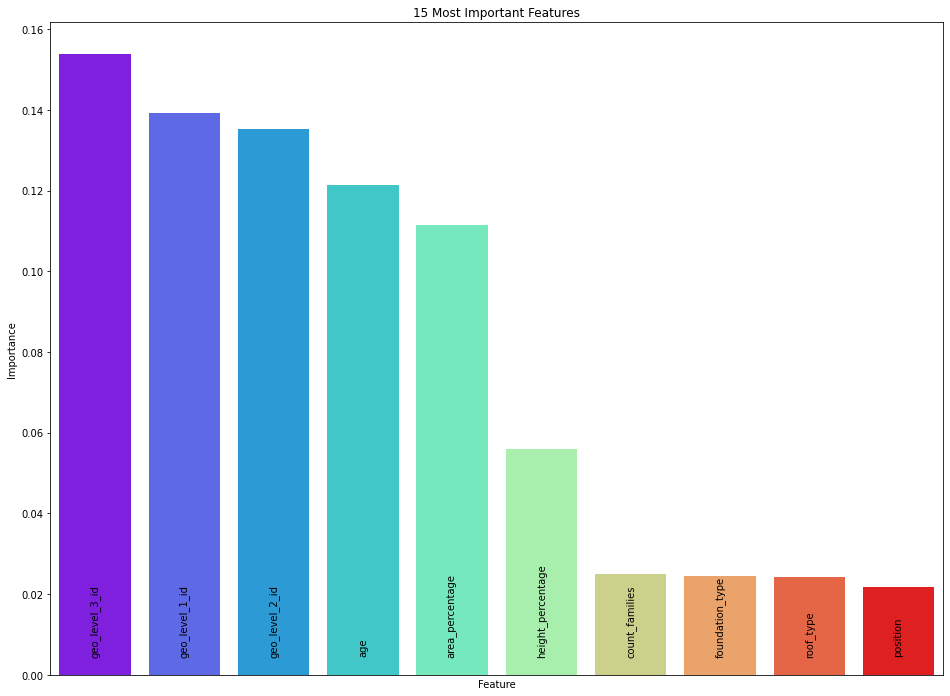

In [55]:
import textwrap
import matplotlib.cm as colors

top=10
importance_10 = importance.head(top)
a4_dims = (16, 12)
fig, ax = plt.subplots(figsize=a4_dims)
plot=sns.barplot(x=importance_10["Feature"], y=importance_10["Importance"], ax=ax, palette = colors.rainbow(np.linspace(0, 1, top)))
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title("15 Most Important Features")


xlocs = plt.xticks()

ax.set_axisbelow(True)

for i in range(top):

  
  texto_fin=""
  texto=importance_10['Feature'].tolist()[i]

  texto_fin =texto_fin+palabra+"\n"
  plt.text(xlocs[0][i],0.005, texto ,ha = "center",rotation=90)

plt.xticks([])
plt.show()

In [ ]:
plt.barh(boston.feature_names, rf.feature_importances_)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

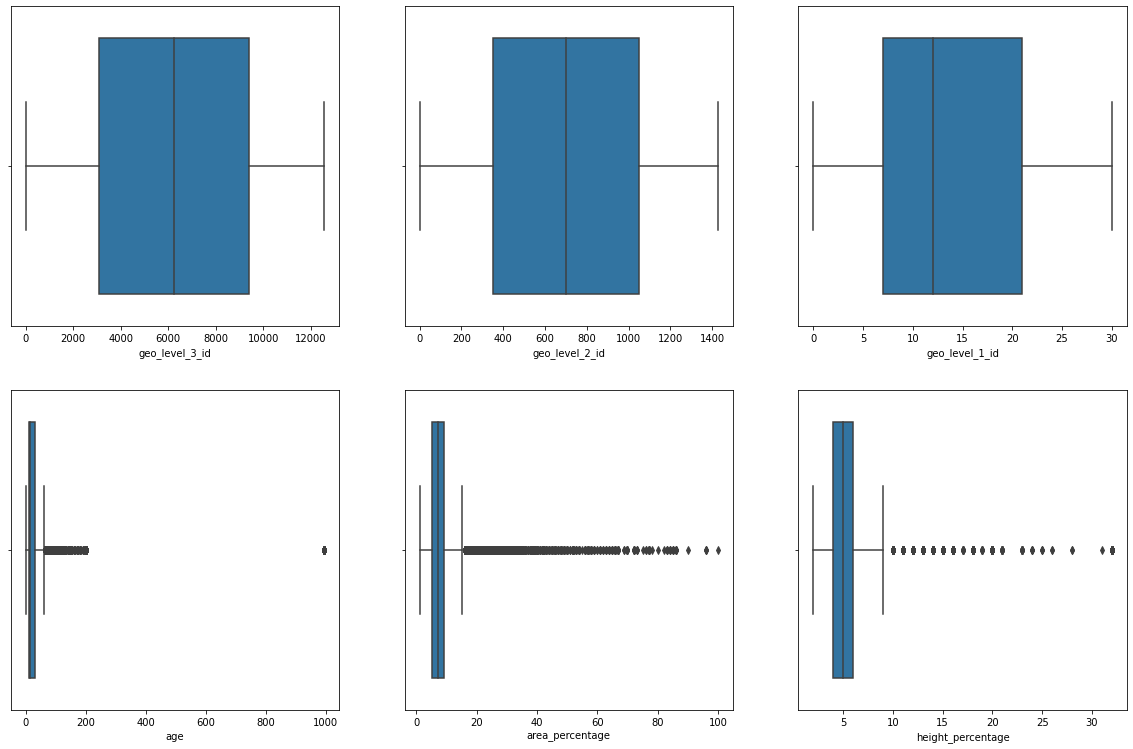

In [ ]:
boxplot_cols=["geo_level_3_id","geo_level_2_id","geo_level_1_id","age", "area_percentage", "height_percentage"]
q=1
plt.figure(figsize=(20,20))
for j in boxplot_cols:
    plt.subplot(3,3,q)
    ax=sns.boxplot(train_values[j].dropna())
    plt.xlabel(j)
    q+=1
plt.show()

Se aprecia que para los de `geo_level_id` no hay outliers, pero para los otros 3 si.

In [ ]:
import scipy

def remove_outliers(df, col_cutoff = 0.01, z_score = 3.5): #define a function to get rid of all outliers of the most important columns
    important_cols = importance[importance.Importance>col_cutoff]['Feature'].tolist() #get all columns with importance > 0.01.  
    df_new = df.copy() #init the new df
    for col in important_cols: df_new = df_new[np.abs(scipy.stats.zscore(df_new[col]))<z_score] #removing all rows where a z-score is >3
    return df_new

In [ ]:
df = pd.concat([train_values, train_labels], axis = 1)

In [ ]:
df_new = remove_outliers(df)

In [ ]:
y = df_new.pop('damage_grade')
x = df_new

In [ ]:
y.value_counts()

2    142749
3     84408
1     23098
Name: damage_grade, dtype: int64

Se removieron un montón de valores `damage_grade` = 1 porque eran outliers, lo que no es muy bueno.

Acá una justificación del valor elegido para el z_score:

Given the size of our dataset, ~ 260,000 samples, considering all variables with z scores > 3, as outliers, corresponding to 0.27% percentile, might be removing some useful data.

A z score of 3.5, corresponding with the 0.0465% could also be good enough to remove outliers, while preserving more samples. This way, the original distrbituion between damage grades may be better preserved too.

In [ ]:
def get_original():
    df = train_values_incomplete.copy()
    #df.drop('building_id', axis =1, inplace=True)
    obj_types = get_obj(df)
    transform_to_int(df, obj_types)
    df['damage_grade'] = train_labels.damage_grade

    return df
    
df = get_original()

In [ ]:
#función para volver a dividir df en train_values y train_labels
def get_xy(df):
    y = df.pop('damage_grade')
    x= df
    return x, y

x,y = get_xy(df) 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)

In [ ]:
def test_model(model, removing = False, col_cutoff = 0.01, z_score = 3.5):
    df_train = pd.concat([x_train, y_train], axis = 1) #combine them together, so outliers are simultaneously removed from both
    if removing: df_train = remove_outliers(df_train, col_cutoff, z_score) 
    x, y = get_xy(df_train)
    model.fit(x, y)

    y_pred = model.predict(x_test)
    print(f1_score(y_test, y_pred, average='micro'))

In [ ]:
test_model(xgb.XGBRFClassifier()) #xgboost con random forest incluido
test_model(xgb.XGBClassifier()) #xgboost normal

0.6357008556847397
0.6757607152450021


In [ ]:
test_model(xgb.XGBClassifier(), True)

0.6755304861670696


In [ ]:
xgbc = xgb.XGBClassifier(min_child_weight= 5, learning_rate= 0.1, gamma= 0.05, subsample= 0.8,colsample_bytree= 0.3, colsample_bynode= 0.8,
 colsample_bylevel= 0.8, max_depth = 20, n_estimators = 150)

In [ ]:
test_model(xgbc)

0.7480910172288093


In [ ]:
def submit_model(model, file_name):
    test = test_values_incomplete.copy()
    transform_to_int(test, get_obj(test))
    submission_predictions = model.predict(test)
    submission = pd.DataFrame()
    submission["building_id"] = test_values_incomplete.reset_index()['building_id']
    submission["damage_grade"] = submission_predictions
    submission.to_csv(file_name, index=False)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
pred = xgbc.predict(x_test)
score = f1_score(y_test, pred, average='micro')
score = accuracy_score(y_test, pred)

cm = confusion_matrix(y_test, pred)
report = classification_report(y_test, pred)

print("f1_micro: ", score, "\n\n")
print(cm, "\n\n")
print(report, "\n\n")

f1_micro:  0.7480910172288093 


[[ 1276  1235    35]
 [  461 12728  1604]
 [   35  3195  5492]] 


              precision    recall  f1-score   support

           1       0.72      0.50      0.59      2546
           2       0.74      0.86      0.80     14793
           3       0.77      0.63      0.69      8722

    accuracy                           0.75     26061
   macro avg       0.74      0.66      0.69     26061
weighted avg       0.75      0.75      0.74     26061
 




In [ ]:
submit_model(xgbc, 'submission_xgb.csv')

# CatBoost (muy buena prueba)

In [ ]:
train_values = train_values_incomplete.copy()
test_values = test_values_incomplete.copy()

In [ ]:
pip install catboost

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
idx = train_values.shape[0]

In [ ]:
data_df = pd.concat([train_values, test_values], sort=False)

In [ ]:
drop_colums = ['count_floors_pre_eq']
data_df = data_df.drop(drop_colums,axis = 1)

In [ ]:
data_df.shape

(347469, 37)

In [ ]:
cat_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 
                    'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']

In [ ]:
data_cat = pd.DataFrame(index = data_df.index, 
                  data = data_df,
                  columns = cat_features)

In [ ]:
data_cat.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
building_id,,,,,,,,,,,
802906,6,487,12198,t,r,n,f,q,t,d,v
28830,8,900,2812,o,r,n,x,q,s,d,v
94947,21,363,8973,t,r,n,f,x,t,d,v
590882,22,418,10694,t,r,n,f,x,s,d,v
201944,11,131,1488,t,r,n,f,x,s,d,v


In [ ]:
data_cat.shape

(347469, 11)

In [ ]:
data_num = data_df.drop(columns = cat_features)
num_features = data_num.columns

In [ ]:
data_num.shape

(347469, 26)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(data_cat)
data_cat_encoded = enc.transform(data_cat)
data_cat_encoded.shape

(347469, 13348)

In [ ]:
scaler = MinMaxScaler()
data_num_scaled = scaler.fit_transform(data_num)

In [ ]:
from scipy.sparse import coo_matrix, hstack
data_num_scaled = coo_matrix(data_num_scaled)

In [ ]:
data = hstack((data_cat_encoded,data_num_scaled))

In [ ]:
data = data.astype(dtype='float16')

In [ ]:
X_train = data.tocsr()[:idx]
X_test = data.tocsr()[idx:]

In [ ]:
y_train = train_labels['damage_grade'].values

In [ ]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
trainXGB = CatBoostClassifier(learning_rate=0.1,depth=9,iterations=1000,l2_leaf_reg = 1.8)

In [ ]:
trainXGB.fit(X_train, y_train)

In [ ]:
y_pred = trainXGB.predict(X_valid_split)
print(f1_score(y_valid_split, y_pred, average='micro'))

0.7431361639262485


In [ ]:
y_pred = trainXGB.predict(X_test)

In [ ]:
predicted_df = pd.DataFrame(y_pred.astype(np.int8), index = test_values.index, columns=['damage_grade'])

In [ ]:
predicted_df.to_csv('catboost_submission1.csv')

# CatBoost iterando varias pruebas

In [ ]:
train_values = train_values_incomplete.copy()
test_values = test_values_incomplete.copy()

In [ ]:
pip install catboost

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
idx = train_values.shape[0]

In [ ]:
data_df = pd.concat([train_values, test_values], sort=False)

In [ ]:
drop_colums = ['count_floors_pre_eq']
data_df = data_df.drop(drop_colums,axis = 1)

In [ ]:
data_df.shape

(347469, 37)

In [ ]:
cat_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 
                    'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']

In [ ]:
data_cat = pd.DataFrame(index = data_df.index, 
                  data = data_df,
                  columns = cat_features)

In [ ]:
data_cat.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
building_id,,,,,,,,,,,
802906,6,487,12198,t,r,n,f,q,t,d,v
28830,8,900,2812,o,r,n,x,q,s,d,v
94947,21,363,8973,t,r,n,f,x,t,d,v
590882,22,418,10694,t,r,n,f,x,s,d,v
201944,11,131,1488,t,r,n,f,x,s,d,v


In [ ]:
data_cat.shape

(347469, 11)

In [ ]:
data_num = data_df.drop(columns = cat_features)
num_features = data_num.columns

In [ ]:
data_num.shape

(347469, 26)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(data_cat)
data_cat_encoded = enc.transform(data_cat)
data_cat_encoded.shape

(347469, 13348)

In [ ]:
scaler = MinMaxScaler()
data_num_scaled = scaler.fit_transform(data_num)

In [ ]:
from scipy.sparse import coo_matrix, hstack
data_num_scaled = coo_matrix(data_num_scaled)

In [ ]:
data = hstack((data_cat_encoded,data_num_scaled))

In [ ]:
data = data.astype(dtype='float16')

In [ ]:
X_train = data.tocsr()[:idx]
X_test = data.tocsr()[idx:]

In [ ]:
y_train = train_labels['damage_grade'].values

In [ ]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
predictions = []
predictions_test = []

for i in range(5):
  trainXGB = CatBoostClassifier(learning_rate=0.1,depth=9,iterations=1000,l2_leaf_reg=1.8, random_seed=i)
  trainXGB.fit(X_train, y_train)
  predictions.append(trainXGB.predict_proba(X_valid_split))
  predictions_test.append(trainXGB.predict_proba(X_test))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Se truncaron las últimas líneas 5000 del resultado de transmisión.
0:	learn: 1.0401457	total: 1.07s	remaining: 17m 54s
1:	learn: 0.9934648	total: 2.2s	remaining: 18m 20s
2:	learn: 0.9542751	total: 3.22s	remaining: 17m 51s
3:	learn: 0.9220056	total: 4.2s	remaining: 17m 26s
4:	learn: 0.8953753	total: 5.18s	remaining: 17m 11s
5:	learn: 0.8728955	total: 6.17s	remaining: 17m 2s
6:	learn: 0.8529340	total: 7.17s	remaining: 16m 56s
7:	learn: 0.8360142	total: 8.16s	remaining: 16m 51s
8:	learn: 0.8215152	total: 9.15s	remaining: 16m 47s
9:	learn: 0.8079878	total: 10.1s	remaining: 16m 42s
10:	learn: 0.7969102	total: 11.1s	remaining: 16m 39s
11:	learn: 0.7876416	total: 12.2s	remaining: 16m 42s
12:	learn: 0.7800713	total: 13.2s	remaining: 16m 42s
13:	learn: 0.7722614	total: 14.2s	remaining: 16m 39s
14:	learn: 0.7655505	total: 15.2s	remaining: 16m 36s
15:	learn: 0.7590186	total: 16.2s	remaining: 16m 35s
16:	learn: 0.7537180	total: 17.2s	remaining: 16m 33s
17:	learn: 0.7484946	total: 18.2s	remaining: 

In [ ]:
def avg(preds, iter):
  sum1 = 0
  sum2 = 0
  sum3 = 0

  for p in preds:
    sum1 += p[iter][0]
    sum2 += p[iter][1]
    sum3 += p[iter][2]

  return [sum1/5, sum2/5, sum3/5]

result = []

for i in range(len(predictions_test[0])):
  avg_l = avg(predictions_test, i)
  result.append(avg_l)

In [ ]:
idxs_winners = []
for r in result:
  m = np.max(r)
  idx = [i for i,j in enumerate(r) if j == m]
  idxs_winners.append(idx[0]+1)

idxs_winners

In [ ]:
len(idxs_winners)

86868

In [ ]:
predicted_df = pd.DataFrame(predictions_test[3].astype(np.int8), index = test_values.index, columns=['damage_grade'])

In [ ]:
#predicted_df.to_csv('catboost_submission2.csv') -> esta es sin predict_proba

In [ ]:
predicted_df2 = pd.DataFrame(idxs_winners, index = test_values.index, columns=['damage_grade'])

In [ ]:
predicted_df2.to_csv('catboost_submission_avg.csv')

In [ ]:
predicted_df2['damage_grade'].value_counts()

2    58606
3    22699
1     5563
Name: damage_grade, dtype: int64